In [4]:
#include("MAB_module.jl")
include("environment.jl")
include("algorithm_base.jl")
include("eps_greedy.jl")
include("rs.jl")
include("lsx.jl")
#include("meta-bandit.jl")
include("tompson_sampling.jl")
include("ucb1tuned.jl")

update! (generic function with 5 methods)

In [5]:
using Plots
using Statistics
#using Base.Threads

In [6]:
mutable struct MYRS <: Algorithm
    env::Environment
    actionValues::Vector{Float64}
    w::Vector{Float64}             #numbers of  rewards.
    l::Vector{Float64}
    average::Vector
    r::Float64
    gamma::Float64
    alpha_r::Float64
    opt::Bool
    test_name::String
    #constructor
    function MYRS(;env::Environment, r::Float64, gamma::Float64, alpha_r::Float64, opt=false, test_name="")
        return new( env,
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    r,
                    gamma,
                    alpha_r,
                    opt,
                    test_name)
    end
end

In [20]:
function init!(algo::MYRS)
    algo.actionValues = zeros(algo.env.arm_num)
    
    for i=1:algo.env.arm_num
        algo.w[i] = eps(0.0)
        algo.l[i] = eps(0.0)
    end
    
    if algo.opt
        sorted_pro = sort(algo.env.arm_pros, rev=true)
        algo.r = (sorted_pro[1] + sorted_pro[2]) / 2
    else
        algo.r = 1.
    end
end

function select_arm(algo::MYRS)
    #return index of maximum value in the action values.
    min = minimum(algo.actionValues)
    vals = [v-min for v in algo.actionValues]
    if 2* > 0.
        ran = rand(0.:vals)
        sum = 0.
        for i=1:algo.env.arm_num
            sum += algo.actionValues[i]
            if ran < sum
                return i
            end
        end
    end
    
    return rand(1:algo.env.arm_num)
    #return greedy(algo)
end

function calc_value(algo::MYRS, selected, reward)
    
    algo.average[selected] = algo.w[selected]  / (algo.w[selected] + algo.l[selected])
    
    if !algo.opt
        algo.r += algo.alpha_r * (algo.average[selected] - algo.r)
        #algo.r += algo.alpha_r * (reward - algo.r)
    end

    
    if algo.test_name == "gamma"
        for i=1:algo.env.arm_num
                algo.w[i] = algo.gamma * algo.w[i]
                algo.l[i] = algo.gamma * algo.l[i]
            
                algo.actionValues[i] = (algo.w[i]+algo.l[i])*(algo.average[i] - algo.r)
        end
    else
        algo.actionValues[selected] = algo.average[selected]#(algo.w[selected]+algo.l[selected])*(algo.average[selected] - algo.r)
    end

    #update this experiment's current state.
    if reward == 1
        algo.w[selected] += 1
    else
        algo.l[selected] += 1
    end
    

    #@show algo.r selected
end

#update each variables and calc parameters for epsilon greedy algorithm
function update!(algo::MYRS)
    selected = select_arm(algo)
    reward = get_reward(algo.env.arm_pros, selected)

    #calculation of action value and save.
    calc_value(algo, selected, reward)

    #calc regret.
    regret = algo.env.max_pro - algo.env.arm_pros[selected]

    return selected, regret, reward

end

update! (generic function with 6 methods)

In [21]:
function simulation(;sim_num::Int, steps::Int, update_pro::Float64, arm_num=4, dynamic=false)
    env = Environment(arm_num)

    algo_dict = Dict()
    
    for gamma=[0.999]
        #gamma = 0.999
        alpha = 0.0005
        #alpha = 1/(10^i)
        algo_dict["RS \\gamma"] = MYRS(env=env, r=1., gamma=gamma, alpha_r=alpha, test_name="gamma")
    end
    algo_dict["RS opt \\gamma"] = MYRS(env=env, r=1., gamma=0.999, alpha_r=0.0005, opt=true, test_name="gamma")
    #algo_dict["RS opt"] = MYRS(env=env, r=1., gamma=0.999, alpha_r=0.0005, opt=true)


    algo_dict["RS"] = RS(env)
    #algo_dict["Tompson_sampling"] = Tompson(env)
    #algo_dict["UCB1-tuned"] = UCB1(env, true)
    
    regret_means, win_means, action_vals = Vector{}(), Vector{}(), Vector{}()
    for algorithm in values(algo_dict)
        regrets, wins = zeros(sim_num, steps), zeros(sim_num, steps)
        #action_val = Vector{}()
        for sim in 1:sim_num
            update_env!(env, rand(arm_num))
            init!(algorithm)
            regret = 0.
            
            for step in 1:steps-1
                selected, rgt, reward = update!(algorithm)

                #save each parameter.
                regret += rgt
                regrets[sim, step] = regret

                if selected == env.correct_arm
                    wins[sim, step] = 1
                end
                
                if dynamic
                    if rand() < update_pro
                        update_env!(env, rand(arm_num))
                        #reset_params(algorithm)
                        if typeof(algorithm) == RS
                            update_r!(algorithm)
                        elseif typeof(algorithm) == LSX && algorithm.opt
                            algorithm.r = opt_r(algorithm.env.arm_pros)
                        elseif typeof(algorithm) == MYRS && algorithm.opt
                            sorted_pro = sort(env.arm_pros, rev=true)
                            algorithm.r = (sorted_pro[1] + sorted_pro[2]) / 2
                        end
                    end
                end

            end
            if sim % 10 == 0
                print("$((sim/sim_num)*100) %")
            end
        end
        push!(regret_means, [mean(regrets[:, i]) for i=1:steps])
        push!(win_means, [mean(wins[:, i]) for i=1:steps])
        #push!(action_vals, vcat(action_val...))
        
    end
    
    println("DONE.")
    
    #@show action_vals

    graph_data = hcat(win_means...)
    time = Vector{Int}(1:steps)
    #xscale=:log

    #graph_data2 = vcat(rslist...)
    #@show size(graph_data2)
    graph_data2 = hcat(regret_means...)

    return graph_data, graph_data2, algo_dict
end

simulation (generic function with 1 method)

In [22]:
@time g1, g2, algo_dict = simulation(sim_num=100,
                            steps=10000,
                            update_pro=1/10000,
                            arm_num=20,
                            dynamic=false);

10.0 %20.0 %30.0 %40.0 %50.0 %60.0 %70.0 %80.0 %90.0 %100.0 %10.0 %20.0 %30.0 %40.0 %50.0 %60.0 %70.0 %80.0 %90.0 %100.0 %10.0 %20.0 %30.0 %40.0 %50.0 %60.0 %70.0 %80.0 %90.0 %100.0 %DONE.
  7.565741 seconds (278.60 M allocations: 5.107 GiB, 4.35% gc time)


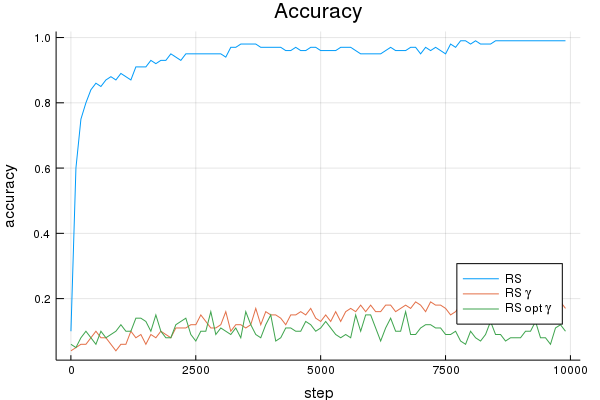

In [23]:
step_axis = [i for i=1:100:size(g1)[1]]
graph = [g1[i, :] for i in step_axis]
graph = hcat(graph...)'
#plot(1:size(g1)[1], g1, label=["RS","RS_tuned"], title="Accuracy")
#plot(step_axis, graph, title="Accuracy", label=[key for key in keys(algo_dict)], legend=:bottomright)
labels = [key for key in keys(algo_dict)]
plot(step_axis, graph, title="Accuracy", label=labels, xlabel="step",ylabel="accuracy", legend=:bottomright, fmt=:png)

In [10]:
# step_axis2 = [i for i=1:10:size(g2)[1]]
# graph2 = [g2[i, :] for i in step_axis2]
# graph2 = hcat(graph2...)'
# #plot(step_axis2, graph2)
# plot(step_axis2, graph2, title="Regret", label=[key for key in keys(algo_dict)], xlabel="step",ylabel="regret", legend=:bottomright)

In [37]:
using CSV
using DataFrames

In [38]:
include("data_save.jl")

save_csv (generic function with 1 method)

In [46]:
save_csv(data=g2, file_name="./exp_data/no_sync_non_steady_regret_1K_100K.csv", labels=labels)

"./exp_data/no_sync_non_steady_regret_1K_100K.csv"

In [43]:
#dataframe = CSV.read("./exp_data/no_sync_non_steady_accuracy_1K_100K_for_graph.csv", delim=',');

In [44]:
#plot(dataframe[1], convert(Array, dataframe[[Symbol(str) for str in labels]]))

MethodError: MethodError: no method matching +(::Array{Float64,1}, ::Float64)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:502
  +(!Matched::Bool, ::T<:AbstractFloat) where T<:AbstractFloat at bool.jl:112
  +(!Matched::Float64, ::Float64) at float.jl:395
  ...